In [2]:
# Step 1: Import libraries
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

2026-01-07 06:24:59.772926: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767767099.978941      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767767100.044669      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767767100.574021      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767767100.574058      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767767100.574061      55 computation_placer.cc:177] computation placer alr

In [3]:
import tensorflow as tf

# Check if GPU is available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs found:", gpus)
else:
    print("No GPU found, using CPU")

# Optional: Set memory growth to prevent TensorFlow from grabbing all GPU memory
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

GPUs found: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [5]:
# Step 2: Set dataset paths
TRAIN_DIR = "/kaggle/input/brain-tumor-mri-dataset/Training"  # Change this to your Kaggle path
TEST_DIR  = "/kaggle/input/brain-tumor-mri-dataset/Testing"   # Change this to your Kaggle path

# Quick check: classes
print("Training classes:", os.listdir(TRAIN_DIR))
print("Testing classes:", os.listdir(TEST_DIR))

Training classes: ['pituitary', 'notumor', 'meningioma', 'glioma']
Testing classes: ['pituitary', 'notumor', 'meningioma', 'glioma']


In [6]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Training generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% data will be used for validation
)

# Training subset
train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='training'   # <-- training data
)

# Validation subset
val_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    subset='validation'  # <-- validation data
)


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


In [7]:

# Step 4: Build ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # Freeze base for feature extraction

# Add custom top layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),               # reduce overfitting
    Dense(4, activation='softmax')  # 4 classes
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


I0000 00:00:1767767151.860088      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1767767151.864083      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [8]:
# Step 5: Train the model
EPOCHS = 25

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


I0000 00:00:1767767190.249223     141 service.cc:152] XLA service 0x7c4ed004be50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767767190.249262     141 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1767767190.249266     141 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1767767192.080564     141 cuda_dnn.cc:529] Loaded cuDNN version 91002


  2/143 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.2734 - loss: 1.4957 

I0000 00:00:1767767197.116942     141 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


143/143 ━━━━━━━━━━━━━━━━━━━━ 105s 644ms/step - accuracy: 0.2769 - loss: 1.5140 - val_accuracy: 0.3401 - val_loss: 1.3484
Epoch 2/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 65s 452ms/step - accuracy: 0.3164 - loss: 1.4225 - val_accuracy: 0.3777 - val_loss: 1.3229
Epoch 3/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 64s 446ms/step - accuracy: 0.3547 - loss: 1.3611 - val_accuracy: 0.4347 - val_loss: 1.2916
Epoch 4/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 63s 444ms/step - accuracy: 0.3729 - loss: 1.3093 - val_accuracy: 0.4189 - val_loss: 1.2752
Epoch 5/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 64s 446ms/step - accuracy: 0.3918 - loss: 1.2811 - val_accuracy: 0.4829 - val_loss: 1.2619
Epoch 6/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 64s 447ms/step - accuracy: 0.4078 - loss: 1.2468 - val_accuracy: 0.4934 - val_loss: 1.2520
Epoch 7/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 64s 446ms/step - accuracy: 0.4235 - loss: 1.2079 - val_accuracy: 0.5355 - val_loss: 1.2398
Epoch 8/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 63s 444ms/step - accuracy: 0.4370 - loss: 1.1951 - va

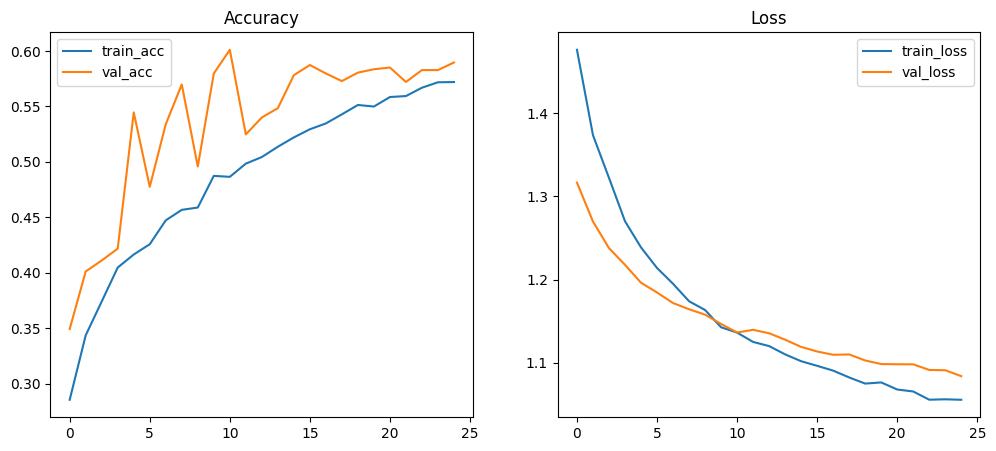

In [8]:
# Step 6: Plot training history
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("Loss")
plt.legend()

plt.show()

In [9]:
# Step 7: Optional fine-tuning (unfreeze last few layers)
# Unfreeze last 10 layers of ResNet50
base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Compile with smaller learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune for additional epochs
FT_EPOCHS = 10
history_ft = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=FT_EPOCHS
)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 99s 466ms/step - accuracy: 0.4568 - loss: 2.4038 - val_accuracy: 0.3814 - val_loss: 1.9225
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 73s 405ms/step - accuracy: 0.6484 - loss: 0.8721 - val_accuracy: 0.4813 - val_loss: 1.2053
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 73s 405ms/step - accuracy: 0.6882 - loss: 0.7844 - val_accuracy: 0.6796 - val_loss: 0.8328
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 73s 409ms/step - accuracy: 0.7134 - loss: 0.7359 - val_accuracy: 0.7178 - val_loss: 0.7172
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 73s 407ms/step - accuracy: 0.7239 - loss: 0.6942 - val_accuracy: 0.7346 - val_loss: 0.7349
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 73s 409ms/step - accuracy: 0.7229 - loss: 0.6892 - val_accuracy: 0.7239 - val_loss: 0.7271
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 73s 406ms/step - accuracy: 0.7494 - loss: 0.6354 - val_accuracy: 0.7338 - val_loss: 0.7069
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 74s 411ms/step - accuracy: 0.7605 - loss: 0

# =========================
# Step: Evaluate on Test Data
# =========================


In [10]:
# Test data generator (only rescale, no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,   # e.g., (224,224)
    batch_size=BATCH_SIZE,
    class_mode='categorical', # because this is multi-class
    shuffle=False             # important! do NOT shuffle for test
)

test_loss, test_acc = model.evaluate(test_gen)
print("Final Test Accuracy:", test_acc)
print("Final Test Loss:", test_loss)


Found 1311 images belonging to 4 classes.
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.6497 - loss: 0.8917
Final Test Accuracy: 0.7581998705863953
Final Test Loss: 0.639220654964447
